In [1]:
import prior
dataset = prior.load_dataset("procthor-10k")

house = dataset["train"][20]

AE: https://api.github.com/repos/allenai/procthor-10k/commits?sha=main
[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 9223.36it/s]


In [1]:
print(house)
rooms = []
for room in house["rooms"]:
    room_poly = [(corner["x"], corner["z"]) for corner in room["floorPolygon"]]
    #print(room["roomType"] + " # " + str(room["floorPolygon"]))
    #print(room["roomType"] + " ?? " + str(room_poly))
    rooms.append((room["roomType"], room_poly))

print(rooms)

for room in rooms:
    print(room[1])

NameError: name 'house' is not defined

In [2]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

point = Point(0.5, 0.5)
polygon = Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])
print(polygon.contains(point))

def is_point_inside_room(point_to_test, room_polygon):
    (x, y, z) = point_to_test
    point = Point(x, z)
    polygon = Polygon(room_polygon)
    return polygon.contains(point)

def what_room_is_point_in(rooms, point):
    for room in rooms:
        if is_point_inside_room(point, room[1]):
            return room[0]
    return "NONE"

True


In [3]:
import glob
import pickle
from room_type import RoomType
from classifier_fusion_type import ClassifierFusionType
from hard_class_behaviour import HardClassBehaviour
from ml_model_type import MLModelType
import random

def find_observed_point_by_pose(pose, room_points):
    #(pos, rot) = pose # ((10.75, 1.57599937915802, 1.0), (30.000003814697266, 0.0, 0))
    result = None
    for rp in room_points:
        if rp['point_pose'] == pose:
            result = rp
            return result
    return result

def process_scene_files(llm_type, fusion_type = ClassifierFusionType.NO_FUSION, what_to_do_with_hard_scenes = HardClassBehaviour.CLASSIFY_WITH_CVM_ONLY):
    #pkl_mistral = "pkl_mistral/diff*.pkl"
    pkl_store = "experiment_data/pkl_" + llm_type + "/scene_descr_train_*.pkl"
    #print(glob.glob(pkl_gemma)) 

    accuracies_per_room_llm = []
    accuracies_per_room_svc = []
    accuracies_per_room_cvm = []
    
    scene_files = glob.glob(pkl_store) # files showing gemma scenes
    #scene_files = ["experiment_data/pkl_" + llm_type + "/scene_descr_train_56.pkl"]

    # per all rooms
    all_rooms_llm_good = 0
    all_rooms_svc_good = 0
    all_rooms_cvm_good = 0
    all_rooms_elapsed_time_llm = 0
    all_rooms_elapsed_time_svc = 0
    all_rooms_elapsed_time_cvm = 0
    all_rooms_total_points = 0
    min_points = 10000000000
    max_points = -1

    min_objs_pp = 10000000000
    max_objs_pp = -1

    min_elapsed_time_llm = 10000000000
    min_elapsed_time_svc = 10000000000
    min_elapsed_time_cvm = 10000000000
    max_elapsed_time_llm = -1
    max_elapsed_time_svc = -1
    max_elapsed_time_cvm = -1

    max_t_labels = set()
    min_t_labels = set()

    total_total_points = 0
    storages_and_offices = 0
    
    for scene_f in scene_files:
        f = open(scene_f,'rb')
        scene = pickle.load(f)
        #print(scene_f.split("/"))
        f_name = scene_f.split("/")[2]
        cor_llm_pkl_path = "experiment_data/pkl_LLAMA/" + f_name # corresponding LLM pkl path
        llm_f = open(cor_llm_pkl_path,'rb')
        llm_scene = pickle.load(llm_f)

        room_points = scene.get_all_points()
        llm_room_points = llm_scene.get_all_points()

#    new_point = {
#        "point_pose" : point_pose,
#        "room_type_llm" : room_type_llm,
#        "room_type_svc" : room_type_svc,
#        "room_type_gt" : room_type_gt,
#        "visible_objects_at_this_point" : visible_objects_at_this_point,
#        "visible_object_names" : set(),
#        "elapsed_time_llm": elapsed_time_llm,
#        "elapsed_time_svc": elapsed_time_svc
#    }

        # per room
        llm_good = 0
        svc_good = 0
        cvm_good = 0
        elapsed_time_llm = 0
        elapsed_time_svc = 0
        elapsed_time_cvm = 0
        total_points = 0

        print(str(len(room_points)) + " " + str(len(llm_room_points)) + " " + cor_llm_pkl_path + " " + scene_f)
        
        for rp in room_points:
            #rp = room_points[i]
            #llm_rp = llm_room_points[i]
            llm_rp = find_observed_point_by_pose(rp['point_pose'], llm_room_points)
            if llm_rp is None: # If we haven't got this point in LLM room point set, then we haven't classified it (because there were no good objects to cllassify on- only common objects, e.g. wall, floor, window)
                llm_rp_room_type = RoomType.NOT_CLASSIFIED
            else:
                llm_rp_room_type = llm_rp["room_type_llm"]
            # if we want to skip points that were classified as STORAGE or OFFICE (not categories that we have in ground truth)
            #if (rp["room_type_svc"] == RoomType.NOT_CLASSIFIED or rp["room_type_cvm"] == RoomType.OFFICE or rp["room_type_cvm"] == RoomType.STORAGE):
            #    continue

            # if we want to skip points that LLM didn't classify (usually when there are only common objects)
            # We want to do that when what_to_do_with_hard_scenes == HardClassBehaviour.CLASSIFY_WITH_NEITHER because that means we don't
            # want to evaluate CVM answer when the answer was not classified with SVC or LLM either. Sort of fair.
            if (llm_rp_room_type == RoomType.NOT_CLASSIFIED and what_to_do_with_hard_scenes == HardClassBehaviour.CLASSIFY_WITH_NEITHER):
                continue

            # If we want to only classify hard cases with CVM and we are running a CVM experiment and this is a hard case, then proceed, otherwise skip
            if (what_to_do_with_hard_scenes == HardClassBehaviour.CLASSIFY_HARD_CASES_ONLY_CVM and llm_type != "LLAMA" and llm_rp_room_type != RoomType.NOT_CLASSIFIED and llm_rp_room_type != RoomType.NOT_KNOWN):
                continue

            if (what_to_do_with_hard_scenes == HardClassBehaviour.GUESS_HARD_CASES_WHEN_LLM and llm_rp_room_type == RoomType.NOT_CLASSIFIED): #  and llm_rp_room_type != RoomType.NOT_KNOWN
                # do we want a guess of 4 or 6 labels?
                if (llm_type == "CHAMELEON_4labels"):
                    llm_rp_room_type = random.choice(RoomType.all_options(False))
                else:
                    llm_rp_room_type = random.choice(RoomType.all_options())

           # If we want to only classify hard cases with CVM and we are running a CVM experiment and this is a hard case, then proceed, otherwise skip
            if (what_to_do_with_hard_scenes == HardClassBehaviour.GUESS_HARD_CASES_ONLY_CVM and llm_type != "LLAMA" and (llm_rp_room_type == RoomType.NOT_CLASSIFIED or llm_rp_room_type == RoomType.NOT_KNOWN)):
                # do we want a guess of 4 or 6 labels?
                if (llm_type == "CHAMELEON_4labels"):
                    rp["room_type_cvm"] = random.choice(RoomType.all_options(False))
                else:
                    rp["room_type_cvm"] = random.choice(RoomType.all_options())
            elif (what_to_do_with_hard_scenes == HardClassBehaviour.GUESS_HARD_CASES_ONLY_CVM and llm_type != "LLAMA" and llm_rp_room_type != RoomType.NOT_CLASSIFIED and llm_rp_room_type != RoomType.NOT_KNOWN):
                continue
            
            ## if we want to re-classify OFFICE and STORAGE as BEDROOM
            #if (rp["room_type_cvm"] == RoomType.OFFICE or rp["room_type_cvm"] == RoomType.STORAGE or rp["room_type_cvm"] == RoomType.NOT_KNOWN):
            #if (rp["room_type_cvm"] == RoomType.OFFICE or rp["room_type_cvm"] == RoomType.STORAGE):
            #    print("MISCLASS: " + rp["room_type_cvm"].name + " " + llm_rp_room_type.name + " " + rp["room_type_gt"].name + " " + str(rp["visible_object_names"]) + " # " + rp['cvm_text'] + " # " + rp["front_view_at_this_point"])
            #    storages_and_offices += 1
            #    rp["room_type_cvm"] = RoomType.BEDROOM

            # if we want to re-classify OFFICE and STORAGE as LIVING ROOM
            #if (rp["room_type_cvm"] == RoomType.OFFICE or rp["room_type_cvm"] == RoomType.STORAGE):
            #    storages_and_offices += 1
            #    rp["room_type_cvm"] = RoomType.LIVING_ROOM

            # if we want to re-classify OFFICE and STORAGE as KITCHEN
            #if (rp["room_type_cvm"] == RoomType.OFFICE or rp["room_type_cvm"] == RoomType.STORAGE):
            #    storages_and_offices += 1
            #    rp["room_type_cvm"] = RoomType.KITCHEN

            ## if we want to re-classify OFFICE and STORAGE as BATHROOM
            #if (rp["room_type_cvm"] == RoomType.OFFICE or rp["room_type_cvm"] == RoomType.STORAGE):
            #    storages_and_offices += 1
            #    rp["room_type_cvm"] = RoomType.BATHROOM

            if (fusion_type == ClassifierFusionType.LLM_THEN_CVM):
                if (what_to_do_with_hard_scenes == HardClassBehaviour.CLASSIFY_WITH_CVM_ONLY):
                    # if we want to combine LLM results with CVM - when LLM hasn't got a clue (NOT_KNOWN or NOT_CLASSIFIED), use CVM result
                    if (llm_rp_room_type != RoomType.NOT_CLASSIFIED and llm_rp_room_type != RoomType.NOT_KNOWN):
                        rp["room_type_cvm"] = llm_rp_room_type
                elif (what_to_do_with_hard_scenes == HardClassBehaviour.CLASSIFY_WITH_CVM_WHAT_LLM_CANNOT):
                    # if we want to combine LLM results with CVM - but only when LLM hasn't got a clue (got NOT_KNOWN), use CVM result
                    if (llm_rp_room_type != RoomType.NOT_CLASSIFIED and llm_rp_room_type != RoomType.NOT_KNOWN):
                        rp["room_type_cvm"] = llm_rp_room_type
                    elif (llm_rp_room_type == RoomType.NOT_CLASSIFIED):
                        continue
            elif (fusion_type == ClassifierFusionType.CVM_THEN_LLM):
                if (what_to_do_with_hard_scenes == HardClassBehaviour.CLASSIFY_WITH_CVM_ONLY):
                    # if we want to combine LLM results with CVM - when CVM doesn't know (NOT_KNOWN or NOT_CLASSIFIED, use LLM result 
                    if (rp["room_type_cvm"] == RoomType.NOT_CLASSIFIED or rp["room_type_cvm"] == RoomType.NOT_KNOWN):
                        rp["room_type_cvm"] = llm_rp_room_type
                elif (what_to_do_with_hard_scenes == HardClassBehaviour.CLASSIFY_WITH_CVM_WHAT_LLM_CANNOT):
                    # if we want to combine LLM results with CVM - but only when CVM hasn't got a clue (got NOT_KNOWN), use CVM result
                    if (rp["room_type_cvm"] == RoomType.NOT_KNOWN):
                        rp["room_type_cvm"] = llm_rp_room_type
                    elif (rp["room_type_cvm"] == RoomType.NOT_CLASSIFIED):
                        continue
            
            total_points += 1
            total_total_points += 1
            all_rooms_total_points += 1
            
            # counting correct classifications per method
            if rp["room_type_gt"] == llm_rp_room_type:
                llm_good += 1
                all_rooms_llm_good += 1
            #if rp["room_type_llm"] != rp["room_type_svc"] and rp["room_type_llm"] != rp["room_type_gt"]:
                #print(rp["room_type_llm"].name + " # " + rp["room_type_svc"].name + " # " + rp["room_type_gt"].name + " # " + str(rp["elapsed_time_llm"]) + " # " + str(rp["elapsed_time_svc"]))
                #print(rp["visible_object_names"])
            
            if rp["room_type_gt"] == rp["room_type_svc"]:
                svc_good += 1
                all_rooms_svc_good += 1

            #if (llm_type.type_of_model() == MLModelType.LLM and rp["room_type_gt"] == rp["room_type_cvm"]):
            if (llm_type != "LLAMA" and rp["room_type_gt"] == rp["room_type_cvm"]):
                cvm_good += 1
                all_rooms_cvm_good += 1

            # collecting inference time
            elapsed_time_llm += rp["elapsed_time_llm"]
            elapsed_time_svc += rp["elapsed_time_svc"]
            if (llm_type != "LLAMA"): elapsed_time_cvm += rp["elapsed_time_cvm"]
            all_rooms_elapsed_time_llm += rp["elapsed_time_llm"]
            all_rooms_elapsed_time_svc += rp["elapsed_time_svc"]
            if (llm_type != "LLAMA"): all_rooms_elapsed_time_cvm += rp["elapsed_time_cvm"]

            # collecting min and max visible objects per point
            if min_objs_pp > len(rp["visible_object_names"]):
                min_objs_pp = len(rp["visible_object_names"])
    
            if max_objs_pp < len(rp["visible_object_names"]):
                max_objs_pp = len(rp["visible_object_names"])

            # collecting min and max inference time
            if min_elapsed_time_llm > rp["elapsed_time_llm"]:
                min_elapsed_time_llm = rp["elapsed_time_llm"]
                min_t_labels = rp["visible_object_names"]
            if max_elapsed_time_llm < rp["elapsed_time_llm"]:
                max_elapsed_time_llm = rp["elapsed_time_llm"]
                max_t_labels = rp["visible_object_names"]
            if min_elapsed_time_svc > rp["elapsed_time_svc"]:
                min_elapsed_time_svc = rp["elapsed_time_svc"]
            if max_elapsed_time_svc < rp["elapsed_time_svc"]:
                max_elapsed_time_svc = rp["elapsed_time_svc"]
            if (llm_type != "LLAMA" and min_elapsed_time_cvm > rp["elapsed_time_cvm"]):
                min_elapsed_time_cvm = rp["elapsed_time_cvm"]
            if (llm_type != "LLAMA" and max_elapsed_time_cvm < rp["elapsed_time_cvm"]):
                max_elapsed_time_cvm = rp["elapsed_time_cvm"]
        
        #print("llm_good = " + str(llm_good / total_points) + " # " + "svc_good = " + str(svc_good / total_points) + " # llm_time_avg = " + str(elapsed_time_llm / total_points) + " # svc_time_avg = " + str(elapsed_time_svc / total_points))

        # collecting min and max points per habitat
        if min_points > total_points:
            min_points = total_points

        if max_points < total_points:
            max_points = total_points

        # calculating mean accuracy per method
        accuracies_per_room_llm.append(llm_good / total_points)
        accuracies_per_room_svc.append(svc_good / total_points)
        accuracies_per_room_cvm.append(cvm_good / total_points)

        llm_f.close()
        f.close()
        #print("\n")
    print("min_points = " + str(min_points) + " # " + " max_points = " + str(max_points) + " # total_total_points=" + str(total_total_points))
    print("min_objs_pp = " + str(min_objs_pp) + " # " + " max_objs_pp = " + str(max_objs_pp))
    print("min_elapsed_time_llm = " + str(min_elapsed_time_llm) + " # " + "max_elapsed_time_llm = " + str(max_elapsed_time_llm))
    print("min_elapsed_time_svc = " + str(min_elapsed_time_svc) + " # " + "max_elapsed_time_svc = " + str(max_elapsed_time_svc))
    print("min_elapsed_time_cvm = " + str(min_elapsed_time_cvm) + " # " + "max_elapsed_time_cvm = " + str(max_elapsed_time_cvm))
    
    print("min_t_labels = " + str(min_t_labels) + " # " + "max_t_labels = " + str(max_t_labels))
    print("storages_and_offices = " + str(storages_and_offices) + " # " + "max_t_labels = " + str(max_t_labels))
    
    #print("mean llm time: " + str(all_rooms_elapsed_time_llm / all_rooms_total_points) + " mean svc time: " + str(all_rooms_elapsed_time_svc / all_rooms_total_points))

    #print("min_points = " + str(min_points) + " # " + "max_points = " + str(max_points))

    # returning mean calculated accuracies and mean inference times
    return (accuracies_per_room_llm, # mean values of mean accuracies
            accuracies_per_room_svc, 
            accuracies_per_room_cvm, 
            (all_rooms_elapsed_time_llm / all_rooms_total_points), # avg times
            (all_rooms_elapsed_time_svc / all_rooms_total_points), 
            (all_rooms_elapsed_time_cvm / all_rooms_total_points), 
            storages_and_offices, # how many storages and offices we had (important for CVM deviation from 4 labels)
            [(all_rooms_llm_good / all_rooms_total_points), (all_rooms_svc_good / all_rooms_total_points), (all_rooms_cvm_good / all_rooms_total_points)]) # normal mean accuracies
#scene_descr_llm_fname = "pkl_mistral/scene_descriptions_llm.pkl"
#scene_descr_svc_fname = "pkl_mistral/scene_descriptions_svc.pkl"
#if (os.path.isfile(scene_descr_llm_fname) and os.path.isfile(scene_descr_svc_fname)):
#    file_llm = open(scene_descr_llm_fname,'rb')
#    file_svc = open(scene_descr_svc_fname,'rb')
#    scene_descriptions_llm = pickle.load(file_llm)

#process_scene_files("mistral")
#process_scene_files("gemma")
#process_scene_files("CHAMELEON")
#process_scene_files("CHAMELEON_full_prompt")
#process_scene_files("MOONDREAM_full_prompt")
#process_scene_files("LLAMA")
#process_scene_files("MOONDREAM_one_word")
num_experiments = 20
res_total = 0
for i in range(num_experiments):
    results = process_scene_files("CHAMELEON_4labels", what_to_do_with_hard_scenes = HardClassBehaviour.GUESS_HARD_CASES_WHEN_LLM)
    res_total += results[0][0]
print("mean accuracy of LLM_with_HTC_guessed: ", (res_total / num_experiments))

245 195 experiment_data/pkl_LLAMA/scene_descr_train_25.pkl experiment_data/pkl_CHAMELEON_4labels/scene_descr_train_25.pkl
94 81 experiment_data/pkl_LLAMA/scene_descr_train_43.pkl experiment_data/pkl_CHAMELEON_4labels/scene_descr_train_43.pkl
78 64 experiment_data/pkl_LLAMA/scene_descr_train_7.pkl experiment_data/pkl_CHAMELEON_4labels/scene_descr_train_7.pkl
179 170 experiment_data/pkl_LLAMA/scene_descr_train_17.pkl experiment_data/pkl_CHAMELEON_4labels/scene_descr_train_17.pkl
189 156 experiment_data/pkl_LLAMA/scene_descr_train_16.pkl experiment_data/pkl_CHAMELEON_4labels/scene_descr_train_16.pkl
137 127 experiment_data/pkl_LLAMA/scene_descr_train_18.pkl experiment_data/pkl_CHAMELEON_4labels/scene_descr_train_18.pkl
160 134 experiment_data/pkl_LLAMA/scene_descr_train_15.pkl experiment_data/pkl_CHAMELEON_4labels/scene_descr_train_15.pkl
146 134 experiment_data/pkl_LLAMA/scene_descr_train_51.pkl experiment_data/pkl_CHAMELEON_4labels/scene_descr_train_51.pkl
153 136 experiment_data/pkl_LL

245 195 experiment_data/pkl_LLAMA/scene_descr_train_25.pkl experiment_data/pkl_CHAMELEON_full_prompt/scene_descr_train_25.pkl
94 81 experiment_data/pkl_LLAMA/scene_descr_train_43.pkl experiment_data/pkl_CHAMELEON_full_prompt/scene_descr_train_43.pkl
78 64 experiment_data/pkl_LLAMA/scene_descr_train_7.pkl experiment_data/pkl_CHAMELEON_full_prompt/scene_descr_train_7.pkl
179 170 experiment_data/pkl_LLAMA/scene_descr_train_17.pkl experiment_data/pkl_CHAMELEON_full_prompt/scene_descr_train_17.pkl
189 156 experiment_data/pkl_LLAMA/scene_descr_train_16.pkl experiment_data/pkl_CHAMELEON_full_prompt/scene_descr_train_16.pkl
137 127 experiment_data/pkl_LLAMA/scene_descr_train_18.pkl experiment_data/pkl_CHAMELEON_full_prompt/scene_descr_train_18.pkl
160 134 experiment_data/pkl_LLAMA/scene_descr_train_15.pkl experiment_data/pkl_CHAMELEON_full_prompt/scene_descr_train_15.pkl
146 134 experiment_data/pkl_LLAMA/scene_descr_train_51.pkl experiment_data/pkl_CHAMELEON_full_prompt/scene_descr_train_51.pk

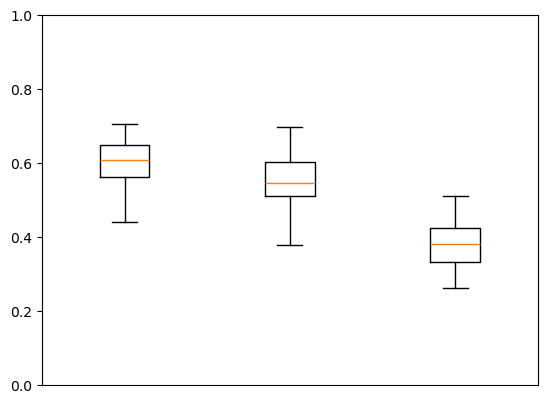

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean

##
# This function will create a box plot for given LLM type accuracies for room classification
##
def testRoomClassifierAccuracy(llm_type):
    (llm_accuracies, svc_accuracies, cvm_accuracies, llm_mean_time, svc_mean_time, cvm_mean_time, storages_and_offices, normal_mean_scores) = process_scene_files(llm_type)
    # should be 3 volumes -- one for LLM and one for SVC and one for CVM for accuracies compared to ground truth.
    number_of_dataset_volumes = 3

    # How many rooms were classified
    number_of_tests_per_dataset_volume = len(llm_accuracies)

    # We'll create an empty Numpy array and put the our SVC accuracies into there.
    dataset_test_results = np.zeros(shape=(number_of_dataset_volumes, number_of_tests_per_dataset_volume))
    #print(dataset_test_results.shape)

    dataset_test_results[0] = llm_accuracies
    dataset_test_results[1] = svc_accuracies
    dataset_test_results[2] = cvm_accuracies

    # transpose it because I imagined it differently to how matplotlib needs the data
    dataset_test_results = np.transpose(dataset_test_results)
    #print(dataset_test_results)
    print("normal_mean_scores = ", normal_mean_scores)
    fig, ax = plt.subplots()
    ax.axes.get_xaxis().set_visible(False)
    #ax7.set_title("Variance while " + operation + " " + gesture + " gesture")
    #if (model_type == ModelType.HYBRID_AT_12):
    #    ax.set_title("Sunrgbd - Hybridized with AI2-THOR data")
    #elif (model_type == ModelType.HYBRID_AT_18):
    #    ax.set_title("Scannet - Hybridized with AI2-THOR data")
    ax.boxplot(dataset_test_results)
    plt.ylim(0.0, 1.0)
    plt.show()

#testRoomClassifierAccuracy("gemma")
#testRoomClassifierAccuracy("mistral")
#testRoomClassifierAccuracy("LLAMA")
testRoomClassifierAccuracy("CHAMELEON_full_prompt")

245 195 experiment_data/pkl_LLAMA/scene_descr_train_25.pkl experiment_data/pkl_CHAMELEON/scene_descr_train_25.pkl
94 81 experiment_data/pkl_LLAMA/scene_descr_train_43.pkl experiment_data/pkl_CHAMELEON/scene_descr_train_43.pkl
78 64 experiment_data/pkl_LLAMA/scene_descr_train_7.pkl experiment_data/pkl_CHAMELEON/scene_descr_train_7.pkl
179 170 experiment_data/pkl_LLAMA/scene_descr_train_17.pkl experiment_data/pkl_CHAMELEON/scene_descr_train_17.pkl
189 156 experiment_data/pkl_LLAMA/scene_descr_train_16.pkl experiment_data/pkl_CHAMELEON/scene_descr_train_16.pkl
137 127 experiment_data/pkl_LLAMA/scene_descr_train_18.pkl experiment_data/pkl_CHAMELEON/scene_descr_train_18.pkl
160 134 experiment_data/pkl_LLAMA/scene_descr_train_15.pkl experiment_data/pkl_CHAMELEON/scene_descr_train_15.pkl
146 134 experiment_data/pkl_LLAMA/scene_descr_train_51.pkl experiment_data/pkl_CHAMELEON/scene_descr_train_51.pkl
153 136 experiment_data/pkl_LLAMA/scene_descr_train_3.pkl experiment_data/pkl_CHAMELEON/scene_

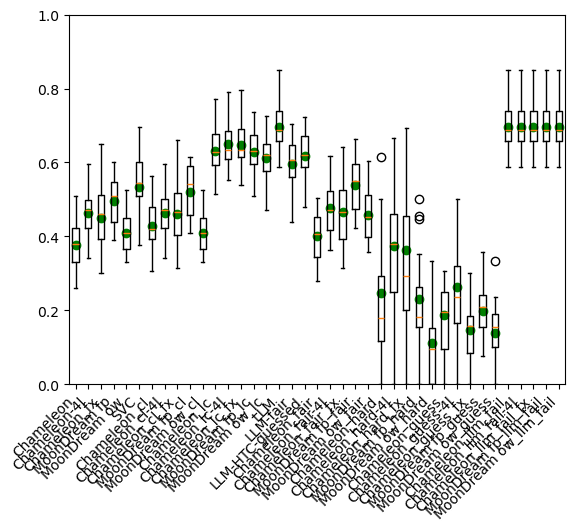

cvm_mean_time_cham = 41.452013970095365
cvm_mean_time_cham_fp = 53.33633196800421
cvm_mean_time_md_fp = 23.509972103689528
cvm_mean_time_md_ow = 11.989318196371952
svc_mean_time = 0.001060590821654307
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


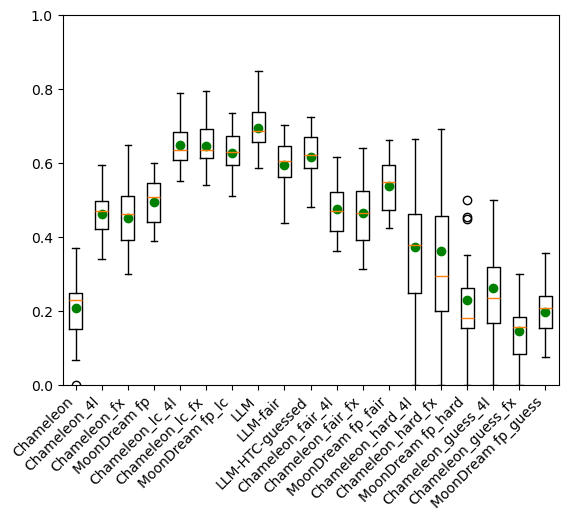

[1 2 3 4 5 6 7]


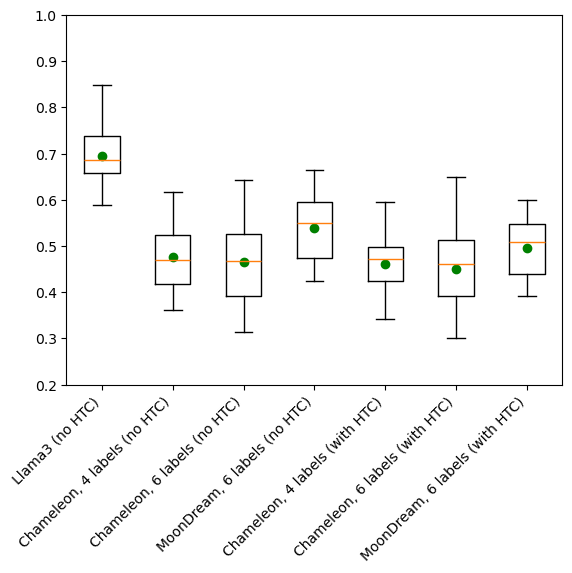

[1 2 3 4 5]


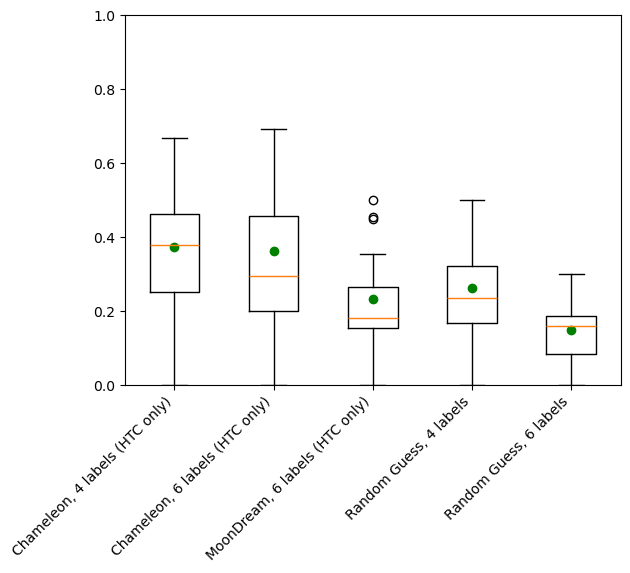

[1 2 3 4 5 6]


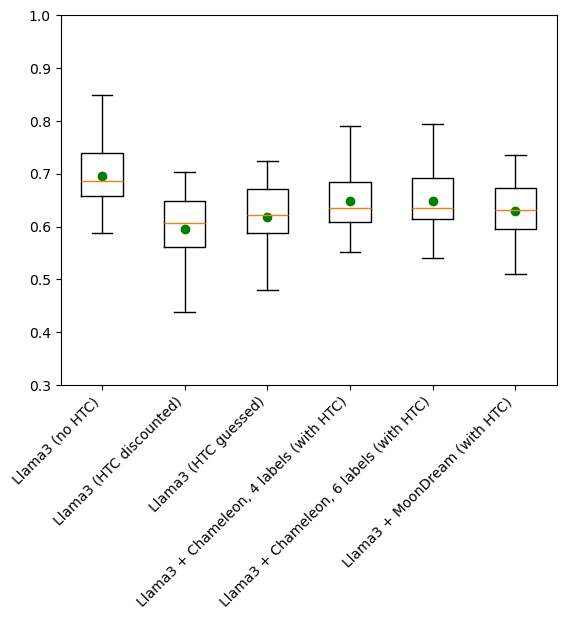

Mean vals: 0.6961394639527206 ## 0.6046702533246948 ## 0.6250602748013291 ## 0.6515135429257296 ## 0.6515567618320259 ## 0.6338887563722139


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean

def plot_my_data(dataset_test_results, normal_mean_results, labels, y_lim_bottom = 0.0):
    fig, ax = plt.subplots()
    ax.axes.get_xaxis().set_visible(False)
    x_positions = np.arange(1, len(labels) + 1)  # Numeric positions for box plots
    ax.boxplot(dataset_test_results, positions=x_positions, labels=labels)
    ax.axes.get_xaxis().set_visible(True)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    plt.ylim(y_lim_bottom, 1.0)
    
    print(x_positions)
    # Line Plot (Secondary Axis)
    #ax1 = ax.twinx()  # Create secondary y-axis
    ax1 = ax
    ax1.scatter(x_positions, normal_mean_results, color='green', marker='o', label="Mean Value")  # Scatter instead of line
    
    plt.show()

##
# This function will create a box plot for a hybridized data set (HYBRID_AT_12 or HYBRID_AT_18)
##
#def testAllRoomClassifiersAccuracy():
(llm_accuracies_fair, svc_accuracies, cvm_accuracies_cham, llm_mean_time, svc_mean_time, cvm_mean_time_cham, storages_and_offices_cham, normal_mean_scores_cham) = process_scene_files("CHAMELEON")
(_, _, cvm_accuracies_cham_fp, llm_mean_time, svc_mean_time, cvm_mean_time_cham_fp, storages_and_offices_cham_fp, normal_mean_scores_cham_fp) = process_scene_files("CHAMELEON_full_prompt")
(_, _, cvm_accuracies_cham_4l, llm_mean_time, svc_mean_time, cvm_mean_time_cham_4l, storages_and_offices_cham_4l, normal_mean_scores_cham_4l) = process_scene_files("CHAMELEON_4labels")
(_, _, cvm_accuracies_cham_fx, llm_mean_time, svc_mean_time, cvm_mean_time_cham_fx, storages_and_offices_cham_fx, normal_mean_scores_cham_fx) = process_scene_files("CHAMELEON_fixed")
(_, _, cvm_accuracies_md_fp, llm_mean_time, svc_mean_time, cvm_mean_time_md_fp, storages_and_offices_md_fp, normal_mean_scores_md_fp) = process_scene_files("MOONDREAM_full_prompt")
(_, _, cvm_accuracies_md_ow, llm_mean_time, svc_mean_time, cvm_mean_time_md_ow, storages_and_offices_md_ow, normal_mean_scores_md_ow) = process_scene_files("MOONDREAM_one_word")

(_, _, cvm_accuracies_cham_fp_llmtcvm, llm_mean_time, svc_mean_time, cvm_mean_time_cham_fp_llmtcvm, storages_and_offices_cham_fp_llmtcvm, normal_mean_scores_cham_fp_llmtcvm) = process_scene_files("CHAMELEON_full_prompt", ClassifierFusionType.LLM_THEN_CVM)
(_, _, cvm_accuracies_cham_4l_llmtcvm, llm_mean_time, svc_mean_time, cvm_mean_time_cham_4l_llmtcvm, storages_and_offices_cham_4l_llmtcvm, normal_mean_scores_cham_4l_llmtcvm) = process_scene_files("CHAMELEON_4labels", ClassifierFusionType.LLM_THEN_CVM)
(_, _, cvm_accuracies_cham_fx_llmtcvm, llm_mean_time, svc_mean_time, cvm_mean_time_cham_fx_llmtcvm, storages_and_offices_cham_fx_llmtcvm, normal_mean_scores_cham_fx_llmtcvm) = process_scene_files("CHAMELEON_fixed", ClassifierFusionType.LLM_THEN_CVM)
(_, _, cvm_accuracies_md_fp_llmtcvm, llm_mean_time, svc_mean_time, cvm_mean_time_md_fp_llmtcvm, storages_and_offices_md_fp_llmtcvm, normal_mean_scores_md_fp_llmtcvm) = process_scene_files("MOONDREAM_full_prompt", ClassifierFusionType.LLM_THEN_CVM)
(_, _, cvm_accuracies_md_ow_llmtcvm, llm_mean_time, svc_mean_time, cvm_mean_time_md_ow_llmtcvm, storages_and_offices_md_ow_llmtcvm, normal_mean_scores_md_ow_llmtcvm) = process_scene_files("MOONDREAM_one_word", ClassifierFusionType.LLM_THEN_CVM)

(_, _, cvm_accuracies_cham_fp_cvmtllm, llm_mean_time, svc_mean_time, cvm_mean_time_cham_fp_cvmtllm, storages_and_offices_cham_fp_cvmtllm, normal_mean_scores_cham_fp_cvmtllm) = process_scene_files("CHAMELEON_full_prompt", ClassifierFusionType.CVM_THEN_LLM)
(_, _, cvm_accuracies_cham_4l_cvmtllm, llm_mean_time, svc_mean_time, cvm_mean_time_cham_4l_cvmtllm, storages_and_offices_cham_4l_cvmtllm, normal_mean_scores_cham_4l_cvmtllm) = process_scene_files("CHAMELEON_4labels", ClassifierFusionType.CVM_THEN_LLM)
(_, _, cvm_accuracies_cham_fx_cvmtllm, llm_mean_time, svc_mean_time, cvm_mean_time_cham_fx_cvmtllm, storages_and_offices_cham_fx_cvmtllm, normal_mean_scores_cham_fx_cvmtllm) = process_scene_files("CHAMELEON_fixed", ClassifierFusionType.CVM_THEN_LLM)
(_, _, cvm_accuracies_md_fp_cvmtllm, llm_mean_time, svc_mean_time, cvm_mean_time_md_fp_cvmtllm, storages_and_offices_md_fp_cvmtllm, normal_mean_scores_md_fp_cvmtllm) = process_scene_files("MOONDREAM_full_prompt", ClassifierFusionType.CVM_THEN_LLM)
(_, _, cvm_accuracies_md_ow_cvmtllm, llm_mean_time, svc_mean_time, cvm_mean_time_md_ow_cvmtllm, storages_and_offices_md_ow_cvmtllm, normal_mean_scores_md_ow_cvmtllm) = process_scene_files("MOONDREAM_one_word", ClassifierFusionType.CVM_THEN_LLM)
(llm_accuracies, _, _, llm_mean_time, svc_mean_time, _, _, normal_mean_scores_llama) = process_scene_files("LLAMA")

(_, _, cvm_accuracies_cham_fp_fair, _, _, _, _, normal_mean_scores_cham_fp_fair) = process_scene_files("CHAMELEON_full_prompt", fusion_type = ClassifierFusionType.NO_FUSION, what_to_do_with_hard_scenes = HardClassBehaviour.CLASSIFY_WITH_NEITHER)
(_, _, cvm_accuracies_cham_4l_fair, _, _, _, _, normal_mean_scores_cham_4l_fair) = process_scene_files("CHAMELEON_4labels", fusion_type = ClassifierFusionType.NO_FUSION, what_to_do_with_hard_scenes = HardClassBehaviour.CLASSIFY_WITH_NEITHER)
(_, _, cvm_accuracies_cham_fx_fair, _, _, _, _, normal_mean_scores_cham_fx_fair) = process_scene_files("CHAMELEON_fixed", fusion_type = ClassifierFusionType.NO_FUSION, what_to_do_with_hard_scenes = HardClassBehaviour.CLASSIFY_WITH_NEITHER)
(_, _, cvm_accuracies_md_fp_fair, _, _, _, _, normal_mean_scores_md_fp_fair) = process_scene_files("MOONDREAM_full_prompt", fusion_type = ClassifierFusionType.NO_FUSION, what_to_do_with_hard_scenes = HardClassBehaviour.CLASSIFY_WITH_NEITHER)
(_, _, cvm_accuracies_md_ow_fair, _, _, _, _, normal_mean_scores_md_ow_fair) = process_scene_files("MOONDREAM_one_word", fusion_type = ClassifierFusionType.NO_FUSION, what_to_do_with_hard_scenes = HardClassBehaviour.CLASSIFY_WITH_NEITHER)

(_, _, cvm_accuracies_cham_fp_hard, _, _, _, _, normal_mean_scores_cham_fp_hard) = process_scene_files("CHAMELEON_full_prompt", fusion_type = ClassifierFusionType.NO_FUSION, what_to_do_with_hard_scenes = HardClassBehaviour.CLASSIFY_HARD_CASES_ONLY_CVM)
(_, _, cvm_accuracies_cham_4l_hard, _, _, _, _, normal_mean_scores_cham_4l_hard) = process_scene_files("CHAMELEON_4labels", fusion_type = ClassifierFusionType.NO_FUSION, what_to_do_with_hard_scenes = HardClassBehaviour.CLASSIFY_HARD_CASES_ONLY_CVM)
(_, _, cvm_accuracies_cham_fx_hard, _, _, _, _, normal_mean_scores_cham_fx_hard) = process_scene_files("CHAMELEON_fixed", fusion_type = ClassifierFusionType.NO_FUSION, what_to_do_with_hard_scenes = HardClassBehaviour.CLASSIFY_HARD_CASES_ONLY_CVM)
(_, _, cvm_accuracies_md_fp_hard, _, _, _, _, normal_mean_scores_md_fp_hard) = process_scene_files("MOONDREAM_full_prompt", fusion_type = ClassifierFusionType.NO_FUSION, what_to_do_with_hard_scenes = HardClassBehaviour.CLASSIFY_HARD_CASES_ONLY_CVM)
(_, _, cvm_accuracies_md_ow_hard, _, _, _, _, normal_mean_scores_md_ow_hard) = process_scene_files("MOONDREAM_one_word", fusion_type = ClassifierFusionType.NO_FUSION, what_to_do_with_hard_scenes = HardClassBehaviour.CLASSIFY_HARD_CASES_ONLY_CVM)

(_, _, cvm_accuracies_cham_fp_guess, _, _, _, _, normal_mean_scores_cham_fp_guess) = process_scene_files("CHAMELEON_full_prompt", fusion_type = ClassifierFusionType.NO_FUSION, what_to_do_with_hard_scenes = HardClassBehaviour.GUESS_HARD_CASES_ONLY_CVM)
(_, _, cvm_accuracies_cham_4l_guess, _, _, _, _, normal_mean_scores_cham_4l_guess) = process_scene_files("CHAMELEON_4labels", fusion_type = ClassifierFusionType.NO_FUSION, what_to_do_with_hard_scenes = HardClassBehaviour.GUESS_HARD_CASES_ONLY_CVM)
(_, _, cvm_accuracies_cham_fx_guess, _, _, _, _, normal_mean_scores_cham_fx_guess) = process_scene_files("CHAMELEON_fixed", fusion_type = ClassifierFusionType.NO_FUSION, what_to_do_with_hard_scenes = HardClassBehaviour.GUESS_HARD_CASES_ONLY_CVM)
(_, _, cvm_accuracies_md_fp_guess, _, _, _, _, normal_mean_scores_md_fp_guess) = process_scene_files("MOONDREAM_full_prompt", fusion_type = ClassifierFusionType.NO_FUSION, what_to_do_with_hard_scenes = HardClassBehaviour.GUESS_HARD_CASES_ONLY_CVM)
(_, _, cvm_accuracies_md_ow_guess, _, _, _, _, normal_mean_scores_md_ow_guess) = process_scene_files("MOONDREAM_one_word", fusion_type = ClassifierFusionType.NO_FUSION, what_to_do_with_hard_scenes = HardClassBehaviour.GUESS_HARD_CASES_ONLY_CVM)

(_, _, cvm_accuracies_cham_fp_llm_fail, _, _, _, _, normal_mean_scores_cham_fp_llm_fail) = process_scene_files("CHAMELEON_full_prompt", fusion_type = ClassifierFusionType.LLM_THEN_CVM, what_to_do_with_hard_scenes = HardClassBehaviour.CLASSIFY_WITH_CVM_WHAT_LLM_CANNOT)
(_, _, cvm_accuracies_cham_4l_llm_fail, _, _, _, _, normal_mean_scores_cham_4l_llm_fail) = process_scene_files("CHAMELEON_4labels", fusion_type = ClassifierFusionType.LLM_THEN_CVM, what_to_do_with_hard_scenes = HardClassBehaviour.CLASSIFY_WITH_CVM_WHAT_LLM_CANNOT)
(_, _, cvm_accuracies_cham_fx_llm_fail, _, _, _, _, normal_mean_scores_cham_fx_llm_fail) = process_scene_files("CHAMELEON_fixed", fusion_type = ClassifierFusionType.LLM_THEN_CVM, what_to_do_with_hard_scenes = HardClassBehaviour.CLASSIFY_WITH_CVM_WHAT_LLM_CANNOT)
(_, _, cvm_accuracies_md_fp_llm_fail, _, _, _, _, normal_mean_scores_md_fp_llm_fail) = process_scene_files("MOONDREAM_full_prompt", fusion_type = ClassifierFusionType.LLM_THEN_CVM, what_to_do_with_hard_scenes = HardClassBehaviour.CLASSIFY_WITH_CVM_WHAT_LLM_CANNOT)
(_, _, cvm_accuracies_md_ow_llm_fail, _, _, _, _, normal_mean_scores_md_ow_llm_fail) = process_scene_files("MOONDREAM_one_word", fusion_type = ClassifierFusionType.LLM_THEN_CVM, what_to_do_with_hard_scenes = HardClassBehaviour.CLASSIFY_WITH_CVM_WHAT_LLM_CANNOT)

(llm_accuracies_htc_guessed, _, _, _, _, _, _, normal_mean_scores_htc_guessed) = process_scene_files("CHAMELEON", what_to_do_with_hard_scenes = HardClassBehaviour.GUESS_HARD_CASES_WHEN_LLM)

# should be two volumes -- one for LLM and one for SVC for accuracies compared to ground truth.
#number_of_dataset_volumes = 11

# How many rooms were classified
#number_of_tests_per_dataset_volume = len(svc_accuracies)
print(str(len(svc_accuracies)) + " " + str(len(cvm_accuracies_cham)) + " " + str(len(cvm_accuracies_cham_fp)) + " " + str(len(cvm_accuracies_md_fp)) + " " + str(len(cvm_accuracies_md_ow)))
print(str(storages_and_offices_cham) + " " + str(storages_and_offices_cham))

# We'll create an empty Numpy array and put the our SVC accuracies into there.
#dataset_test_results = np.zeros(shape=(number_of_dataset_volumes, number_of_tests_per_dataset_volume))
#print(dataset_test_results.shape)

#    dataset_test_results[0] = cvm_accuracies_cham
#    dataset_test_results[1] = cvm_accuracies_cham_fp
#    dataset_test_results[2] = cvm_accuracies_md_fp
#    dataset_test_results[3] = cvm_accuracies_md_ow
#    dataset_test_results[4] = svc_accuracies

#dataset_test_results = [cvm_accuracies_cham, cvm_accuracies_cham_fp, cvm_accuracies_md_fp, cvm_accuracies_md_ow, svc_accuracies]
dataset_test_results = [cvm_accuracies_cham_fp, cvm_accuracies_cham_4l, cvm_accuracies_cham_fx, cvm_accuracies_md_fp, cvm_accuracies_md_ow, 
                        svc_accuracies, 
                        cvm_accuracies_cham_fp_cvmtllm, cvm_accuracies_cham_4l_cvmtllm, cvm_accuracies_cham_fx_cvmtllm, cvm_accuracies_md_fp_cvmtllm, cvm_accuracies_md_ow_cvmtllm, 
                        cvm_accuracies_cham_fp_llmtcvm, cvm_accuracies_cham_4l_llmtcvm, cvm_accuracies_cham_fx_llmtcvm, cvm_accuracies_md_fp_llmtcvm, cvm_accuracies_md_ow_llmtcvm, 
                        llm_accuracies, 
                        llm_accuracies_fair, 
                        llm_accuracies_htc_guessed,
                        cvm_accuracies_cham_fp_fair, cvm_accuracies_cham_4l_fair, cvm_accuracies_cham_fx_fair, cvm_accuracies_md_fp_fair, cvm_accuracies_md_ow_fair, 
                        cvm_accuracies_cham_fp_hard, cvm_accuracies_cham_4l_hard, cvm_accuracies_cham_fx_hard, cvm_accuracies_md_fp_hard, cvm_accuracies_md_ow_hard, 
                        cvm_accuracies_cham_fp_guess, cvm_accuracies_cham_4l_guess, cvm_accuracies_cham_fx_guess, cvm_accuracies_md_fp_guess, cvm_accuracies_md_ow_guess, 
                        cvm_accuracies_cham_fp_llm_fail, cvm_accuracies_cham_4l_llm_fail, cvm_accuracies_cham_fx_llm_fail, cvm_accuracies_md_fp_llm_fail, cvm_accuracies_md_ow_llm_fail]

normal_mean_results = [normal_mean_scores_cham_fp[2], normal_mean_scores_cham_4l[2], normal_mean_scores_cham_fx[2], normal_mean_scores_md_fp[2], normal_mean_scores_md_ow_cvmtllm[2],
                       normal_mean_scores_cham[1], 
                       normal_mean_scores_cham_fp_cvmtllm[2], normal_mean_scores_cham_4l_cvmtllm[2], normal_mean_scores_cham_fx_cvmtllm[2], normal_mean_scores_md_fp_cvmtllm[2], normal_mean_scores_md_ow_cvmtllm[2],
                       normal_mean_scores_cham_fp_llmtcvm[2], normal_mean_scores_cham_4l_llmtcvm[2], normal_mean_scores_cham_fx_llmtcvm[2], normal_mean_scores_md_fp_llmtcvm[2], normal_mean_scores_md_ow_llmtcvm[2],
                       normal_mean_scores_llama[0],
                       normal_mean_scores_cham[0],
                       normal_mean_scores_htc_guessed[0],
                       normal_mean_scores_cham_fp_fair[2], normal_mean_scores_cham_4l_fair[2], normal_mean_scores_cham_fx_fair[2], normal_mean_scores_md_fp_fair[2], normal_mean_scores_md_ow_fair[2],
                       normal_mean_scores_cham_fp_hard[2], normal_mean_scores_cham_4l_hard[2], normal_mean_scores_cham_fx_hard[2], normal_mean_scores_md_fp_hard[2], normal_mean_scores_md_ow_hard[2],
                       normal_mean_scores_cham_fp_guess[2], normal_mean_scores_cham_4l_guess[2], normal_mean_scores_cham_fx_guess[2], normal_mean_scores_md_fp_guess[2], normal_mean_scores_md_ow_guess[2],
                       normal_mean_scores_cham_fp_llm_fail[2], normal_mean_scores_cham_4l_llm_fail[2], normal_mean_scores_cham_fx_llm_fail[2], normal_mean_scores_md_fp_llm_fail[2], normal_mean_scores_md_ow_llm_fail[2]]

# transpose it because I imagined it differently to how matplotlib needs the data
dataset_test_results = np.transpose(dataset_test_results)
##print(dataset_test_results)
#fig, ax = plt.subplots()
#ax.axes.get_xaxis().set_visible(False)
##ax7.set_title("Variance while " + operation + " " + gesture + " gesture")
##if (model_type == ModelType.HYBRID_AT_12):
##    ax.set_title("Sunrgbd - Hybridized with AI2-THOR data")
##elif (model_type == ModelType.HYBRID_AT_18):
##    ax.set_title("Scannet - Hybridized with AI2-THOR data")
##ax.boxplot(dataset_test_results, labels=['Chameleon', 'Chameleon fp', 'MoonDream fp', 'MoonDream ow', 'SVC'])
labels=['Chameleon', 'Chameleon-4l', 'Chameleon_fx', 'MoonDream fp', 'MoonDream ow', 
        'SVC', 
        'Chameleon_cl', 'Chameleon_cl-4l', 'Chameleon_cl_fx', 'MoonDream fp_cl', 'MoonDream ow_cl', 
        'Chameleon_lc', 'Chameleon_lc-4l', 'Chameleon_lc_fx', 'MoonDream fp_lc', 'MoonDream ow_lc', 
        'LLM', 
        'LLM-fair', 
        'LLM-HTC-guessed',
        'Chameleon_fair', 'Chameleon_fair-4l', 'Chameleon_fair_fx', 'MoonDream fp_fair', 'MoonDream ow_fair', 
        'Chameleon_hard', 'Chameleon_hard-4l', 'Chameleon_hard_fx', 'MoonDream fp_hard', 'MoonDream ow_hard', 
        'Chameleon_guess', 'Chameleon_guess-4l', 'Chameleon_guess_fx', 'MoonDream fp_guess', 'MoonDream ow_guess', 
        'Chameleon_llm_fail', 'Chameleon_llm_fail-4l', 'Chameleon_llm_fail_fx', 'MoonDream fp_llm_fail', 'MoonDream ow_llm_fail']

plot_my_data(dataset_test_results, normal_mean_results, labels)

print("cvm_mean_time_cham = " + str(cvm_mean_time_cham))
print("cvm_mean_time_cham_fp = " + str(cvm_mean_time_cham_fp))
print("cvm_mean_time_md_fp = " + str(cvm_mean_time_md_fp))
print("cvm_mean_time_md_ow = " + str(cvm_mean_time_md_ow))
print("svc_mean_time = " + str(svc_mean_time))


# Interim chart
dataset_test_results = [cvm_accuracies_cham, cvm_accuracies_cham_4l, cvm_accuracies_cham_fx, cvm_accuracies_md_fp, 
                        cvm_accuracies_cham_4l_llmtcvm, cvm_accuracies_cham_fx_llmtcvm, cvm_accuracies_md_fp_llmtcvm, 
                        llm_accuracies, 
                        llm_accuracies_fair, 
                        llm_accuracies_htc_guessed,
                        cvm_accuracies_cham_4l_fair, cvm_accuracies_cham_fx_fair, cvm_accuracies_md_fp_fair, 
                        cvm_accuracies_cham_4l_hard, cvm_accuracies_cham_fx_hard, cvm_accuracies_md_fp_hard, 
                        cvm_accuracies_cham_4l_guess, cvm_accuracies_cham_fx_guess, cvm_accuracies_md_fp_guess]

normal_mean_results = [normal_mean_scores_cham[2], normal_mean_scores_cham_4l[2], normal_mean_scores_cham_fx[2], normal_mean_scores_md_fp[2],
                       normal_mean_scores_cham_4l_llmtcvm[2], normal_mean_scores_cham_fx_llmtcvm[2], normal_mean_scores_md_fp_llmtcvm[2],
                       normal_mean_scores_llama[0],
                       normal_mean_scores_cham[0],
                       normal_mean_scores_htc_guessed[0],
                       normal_mean_scores_cham_4l_fair[2], normal_mean_scores_cham_fx_fair[2], normal_mean_scores_md_fp_fair[2],
                       normal_mean_scores_cham_4l_hard[2], normal_mean_scores_cham_fx_hard[2], normal_mean_scores_md_fp_hard[2],
                       normal_mean_scores_cham_4l_guess[2], normal_mean_scores_cham_fx_guess[2], normal_mean_scores_md_fp_guess[2]]

# transpose it because I imagined it differently to how matplotlib needs the data
dataset_test_results = np.transpose(dataset_test_results)

labels=['Chameleon', 'Chameleon_4l', 'Chameleon_fx', 'MoonDream fp',
        'Chameleon_lc_4l', 'Chameleon_lc_fx', 'MoonDream fp_lc', 
        'LLM', 
        'LLM-fair', 
        'LLM-HTC-guessed',
        'Chameleon_fair_4l', 'Chameleon_fair_fx', 'MoonDream fp_fair', 
        'Chameleon_hard_4l', 'Chameleon_hard_fx', 'MoonDream fp_hard',  
        'Chameleon_guess_4l', 'Chameleon_guess_fx', 'MoonDream fp_guess']

plot_my_data(dataset_test_results, normal_mean_results, labels)


# CVM and LLM comparison
dataset_test_results = [llm_accuracies, cvm_accuracies_cham_4l_fair, cvm_accuracies_cham_fx_fair, cvm_accuracies_md_fp_fair, 
                        cvm_accuracies_cham_4l, cvm_accuracies_cham_fx, cvm_accuracies_md_fp]

normal_mean_results = [normal_mean_scores_llama[0], normal_mean_scores_cham_4l_fair[2], normal_mean_scores_cham_fx_fair[2], normal_mean_scores_md_fp_fair[2],
                       normal_mean_scores_cham_4l[2], normal_mean_scores_cham_fx[2], normal_mean_scores_md_fp[2]]

# transpose it because I imagined it differently to how matplotlib needs the data
dataset_test_results = np.transpose(dataset_test_results)
#print(dataset_test_results)

labels=['Llama3 (no HTC)', 'Chameleon, 4 labels (no HTC)', 'Chameleon, 6 labels (no HTC)', 'MoonDream, 6 labels (no HTC)', 
        'Chameleon, 4 labels (with HTC)', 'Chameleon, 6 labels (with HTC)', 'MoonDream, 6 labels (with HTC)']

plot_my_data(dataset_test_results, normal_mean_results, labels, 0.2)

# Hard part analysis
dataset_test_results = [cvm_accuracies_cham_4l_hard, cvm_accuracies_cham_fx_hard, cvm_accuracies_md_fp_hard, 
                        cvm_accuracies_cham_4l_guess, cvm_accuracies_cham_fx_guess]

normal_mean_results = [normal_mean_scores_cham_4l_hard[2], normal_mean_scores_cham_fx_hard[2], normal_mean_scores_md_fp_hard[2],
                       normal_mean_scores_cham_4l_guess[2], normal_mean_scores_cham_fx_guess[2]]

# transpose it because I imagined it differently to how matplotlib needs the data
dataset_test_results = np.transpose(dataset_test_results)
#print(dataset_test_results)

labels=['Chameleon, 4 labels (HTC only)', 'Chameleon, 6 labels (HTC only)', 'MoonDream, 6 labels (HTC only)',  
        'Random Guess, 4 labels', 'Random Guess, 6 labels']

plot_my_data(dataset_test_results, normal_mean_results, labels)

# Fused results
dataset_test_results = [llm_accuracies, 
                        llm_accuracies_fair,
                        llm_accuracies_htc_guessed,
                        cvm_accuracies_cham_4l_llmtcvm, cvm_accuracies_cham_fx_llmtcvm, cvm_accuracies_md_fp_llmtcvm]

normal_mean_results = [normal_mean_scores_llama[0],
                       normal_mean_scores_cham[0],
                       normal_mean_scores_htc_guessed[0],
                       normal_mean_scores_cham_4l_llmtcvm[2], normal_mean_scores_cham_fx_llmtcvm[2], normal_mean_scores_md_fp_llmtcvm[2]]

# transpose it because I imagined it differently to how matplotlib needs the data
dataset_test_results = np.transpose(dataset_test_results)

labels=['Llama3 (no HTC)', 
        'Llama3 (HTC discounted)', 
        'Llama3 (HTC guessed)', 
        'Llama3 + Chameleon, 4 labels (with HTC)', 'Llama3 + Chameleon, 6 labels (with HTC)', 'Llama3 + MoonDream (with HTC)']

plot_my_data(dataset_test_results, normal_mean_results, labels, 0.3)

print("Mean vals: " + str(mean(llm_accuracies)) + " ## " + str(mean(llm_accuracies_fair)) + " ## " + str(mean(llm_accuracies_htc_guessed)) + " ## " + str(mean(cvm_accuracies_cham_4l_llmtcvm)) + " ## " + str(mean(cvm_accuracies_cham_fx_llmtcvm)) + " ## " + str(mean(cvm_accuracies_md_fp_llmtcvm)))


#testAllRoomClassifiersAccuracy()

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


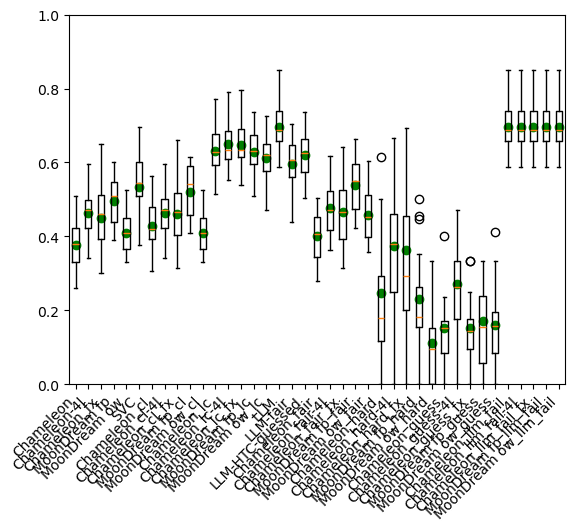

In [28]:
x_positions = np.arange(1, len(labels) + 1)  # Numeric positions for box plots
fig, ax = plt.subplots()
ax.axes.get_xaxis().set_visible(False)
ax.boxplot(dataset_test_results, positions=x_positions, labels=labels)
ax.axes.get_xaxis().set_visible(True)
ax.set_xticklabels(labels, rotation=45, ha='right')
plt.ylim(0.0, 1.0)
#plt.xticks([1, 2, 3], ['mon', 'tue', 'wed'])

print(x_positions)
# Line Plot (Secondary Axis)
#ax1 = ax.twinx()  # Create secondary y-axis
ax1 = ax

ax1.scatter(x_positions, normal_mean_results, color='green', marker='o', label="Mean Value")  # Scatter instead of line

#ax1.plot(x_positions, normal_mean_results, color='red', linestyle='-', label="Mean Value")
#ax1.set_ylabel('Mean Value (Line Plot)')

# Title and Legend
#ax1.legend(loc="upper left")

plt.show()